# Analysis

I conducted an analysis employing diverse classifiers including LightGBM, RandomForest, SVM, KNN Classifiers, Logistic Regression, and a Neural Network to forecast the winning team 15 minutes into the game. Despite employing this array of classifiers, the predictive accuracy achieved using our current feature set hovered around 76%, with an AUC score ranging between 0.85 and 0.86. These metrics suggest that the model performs adequately, but there is room for enhancement. In future iterations, I plan to explore techniques such as Principal Component Analysis (PCA) to join select features and leverage clustering algorithms to construct new features for similar game scenarios.

See the kaggle page I created for this dataset [here](https://www.kaggle.com/datasets/jakejoeanderson/league-of-legends-diamond-matches-ff15/data)

In [27]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

In [28]:
df = pd.read_csv("LoL_15_Diamond.csv")

## Simplifying dataset
Not looking into lane specifics, dragon specifics, feature engineering differences between teams, with negative numbers implying a Red Team Advantage, and positive implying Blue Advantage. It is not recommended to select features by *brain*, in future analyses I plan to use PCA to try to combine some of the more specific variables.

In [29]:
columns_to_keep = ['blue_Win', 'blue_Wards', 'blue_Wards_Destroyed', 'blue_First_Blood',
                   'blue_Kills', 'blue_Aces', 'blue_Assists', 'blue_Void_Grubs', 'blue_Dragons',
                   'blue_Heralds', 'blue_Towers_Destroyed', 'blue_Turret_Plates', 'blue_Inhibitors',
                   'blue_Total_CS', 'blue_Total_Jungle_Monsters', 'blue_Gold_Diff', 'blue_XP_Diff',
                   'blue_Total_Dmg', 'red_Wards', 'red_Wards_Destroyed', 'red_Kills', 'red_Aces',
                   'red_Assists', 'red_Void_Grubs', 'red_Dragons', 'red_Heralds', 'red_Towers_Destroyed',
                   'red_Turret_Plates', 'red_Inhibitors', 'red_Total_CS','red_Total_Jungle_Monsters', 'red_Total_Dmg']

df = df[columns_to_keep]

df.loc[:, 'Ward_Diff'] = df['blue_Wards'] - df['red_Wards']
df.loc[:, 'Wards_Destroyed_Diff'] = df['blue_Wards_Destroyed'] - df['red_Wards_Destroyed']
df.loc[:, 'First_Blood'] = df['blue_First_Blood']
df.loc[:, 'Ace_Diff'] = df['blue_Aces'] - df['red_Aces']
df.loc[:, 'Assist_Diff'] = df['blue_Assists'] - df['red_Assists']
df.loc[:, 'Towers_Destroyed_Diff'] = df['blue_Towers_Destroyed'] - df['red_Towers_Destroyed']
df.loc[:, 'Tower_Plates_Diff'] = df['blue_Turret_Plates'] - df['red_Turret_Plates']
df.loc[:, 'Inhibitor_Diff'] = df['blue_Inhibitors'] - df['red_Inhibitors']

df.loc[:, 'Dmg_Diff'] = df['blue_Total_Dmg'] - df['red_Total_Dmg']
df.loc[:, 'Kill_Diff'] = df['blue_Kills'] - df['red_Kills']
df.loc[:, 'CS_Diff'] = df['blue_Total_CS'] - df['red_Total_CS']
df.loc[:, 'JG_Monster_Diff'] = df['blue_Total_Jungle_Monsters'] - df['red_Total_Jungle_Monsters']
df.loc[:, 'Gold_Diff'] = df['blue_Gold_Diff']
df.loc[:, 'XP_Diff'] = df['blue_XP_Diff']
df.loc[:, 'Dragon_Diff'] = df['blue_Dragons'] - df['red_Dragons']
df.loc[:, 'Void_Grub_Diff'] = df['blue_Void_Grubs'] - df['red_Void_Grubs']
df.loc[:, 'Herald_Diff'] = df['blue_Heralds'] - df['red_Heralds']

df.drop(columns=['blue_Total_Dmg', 'red_Total_Dmg', 'blue_Kills', 'red_Kills', 'blue_Total_CS', 'red_Total_CS',
                 'blue_Total_Jungle_Monsters', 'red_Total_Jungle_Monsters', 'blue_Gold_Diff', 'blue_XP_Diff',
                 'blue_Dragons', 'red_Dragons','blue_Void_Grubs', 'red_Void_Grubs', 'blue_Heralds', 'red_Heralds',
                 'blue_Wards', 'red_Wards', 'blue_Wards_Destroyed', 'red_Wards_Destroyed', 'blue_First_Blood',
                 'blue_Aces', 'red_Aces', 'blue_Assists', 'red_Assists', 'blue_Towers_Destroyed', 'red_Towers_Destroyed',
                 'blue_Turret_Plates', 'red_Turret_Plates', 'blue_Inhibitors', 'red_Inhibitors'], inplace=True)

## Data Exploration

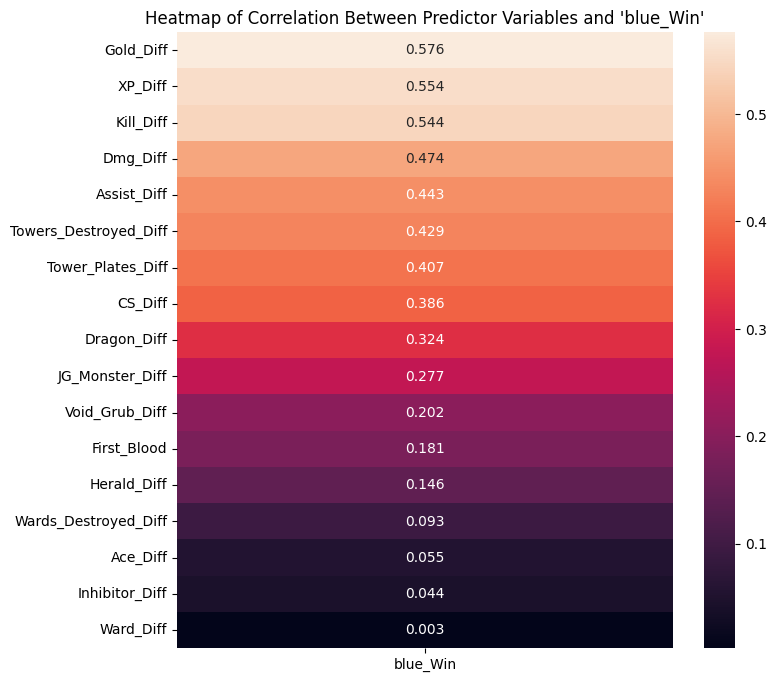

In [30]:
correlation_matrix = df.corr()
target_correlation = correlation_matrix.iloc[1:, 0]
target_correlation = target_correlation.to_frame(name=correlation_matrix.columns[0])
target_correlation = target_correlation.sort_values(by=target_correlation.columns[0], ascending=False)

plt.figure(figsize=(8, 8))
sns.heatmap(target_correlation, cmap="rocket", annot=True, fmt='.3f')

plt.title("Heatmap of Correlation Between Predictor Variables and 'blue_Win'")
plt.show()

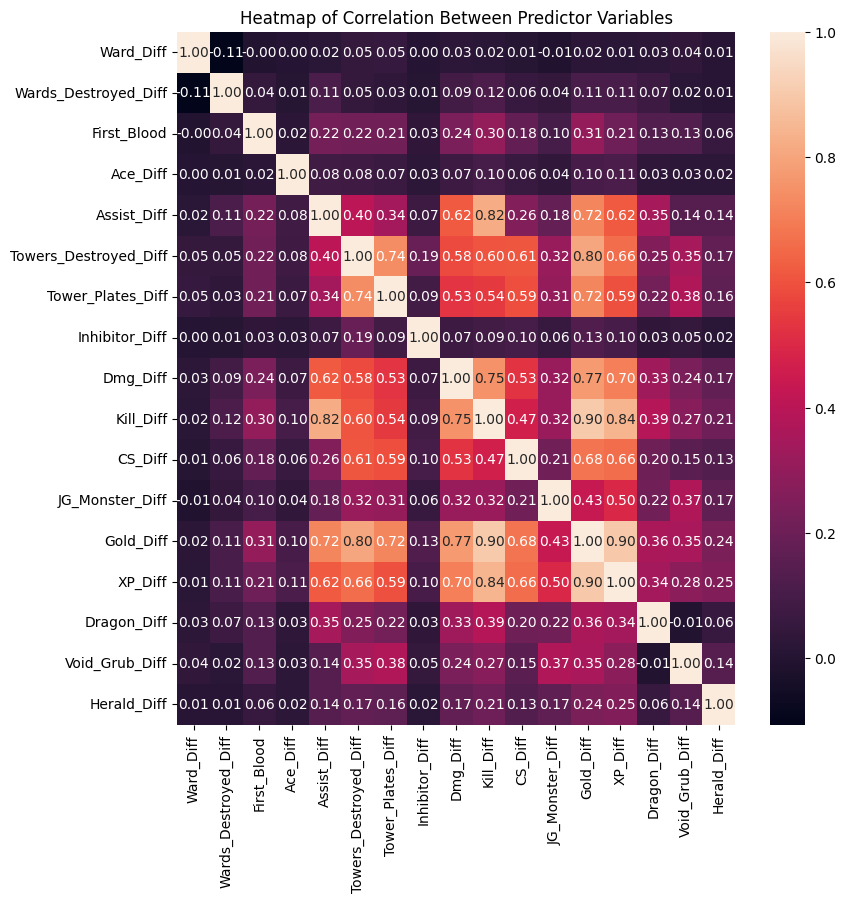

In [31]:
X = df.drop(columns=['blue_Win'])
y = df['blue_Win']

plt.figure(figsize=(9, 9))
sns.heatmap(X.corr(), cmap="rocket", annot=True, fmt='.2f')

plt.title("Heatmap of Correlation Between Predictor Variables")
plt.show()

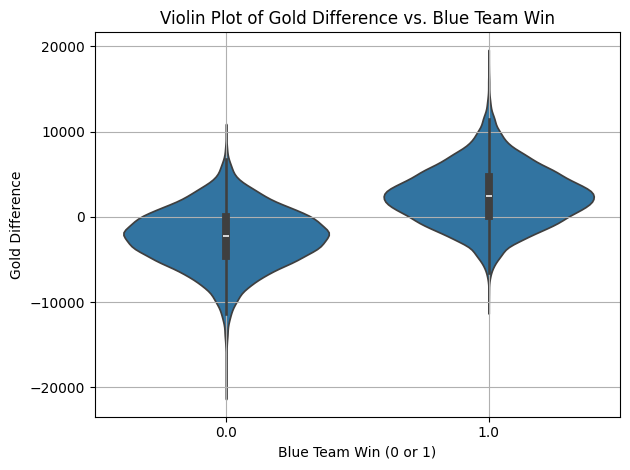

In [32]:
sns.violinplot(x='blue_Win', y='Gold_Diff', data=df)

# Add labels and title
plt.xlabel('Blue Team Win (0 or 1)')
plt.ylabel('Gold Difference')
plt.title('Violin Plot of Gold Difference vs. Blue Team Win')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

## Modeling: Logistic Regression

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_reg = LogisticRegression(penalty='l2')
logistic_reg.fit(X_train_scaled, y_train)

y_pred = logistic_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

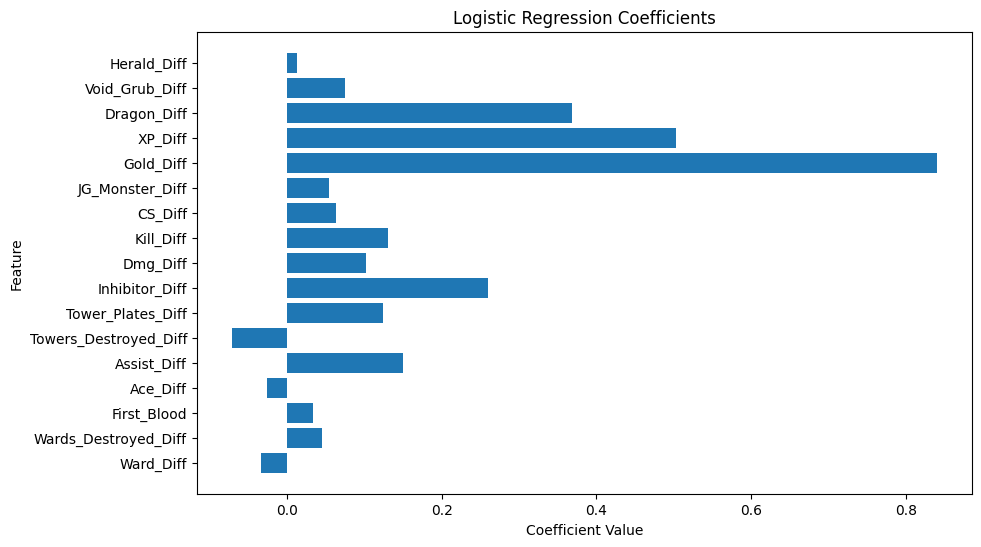

In [34]:
coefficients = logistic_reg.coef_[0]
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

In [35]:
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7529630490355566
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75      2196
         1.0       0.74      0.76      0.75      2107

    accuracy                           0.75      4303
   macro avg       0.75      0.75      0.75      4303
weighted avg       0.75      0.75      0.75      4303

Confusion Matrix:
[[1629  567]
 [ 496 1611]]


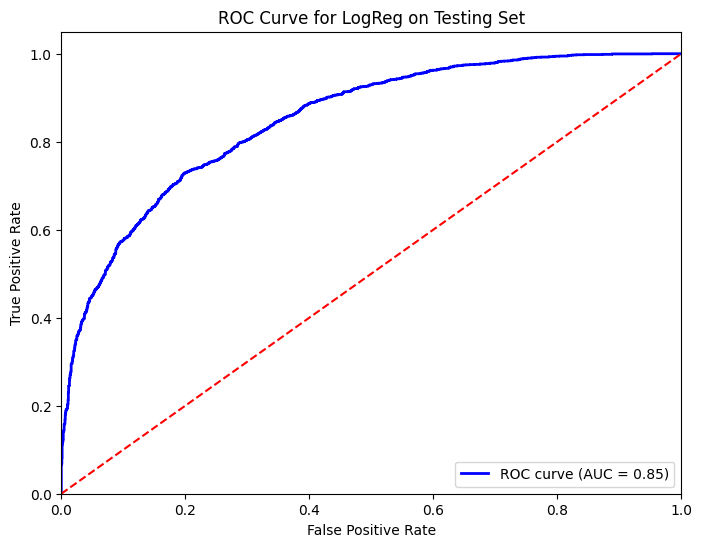

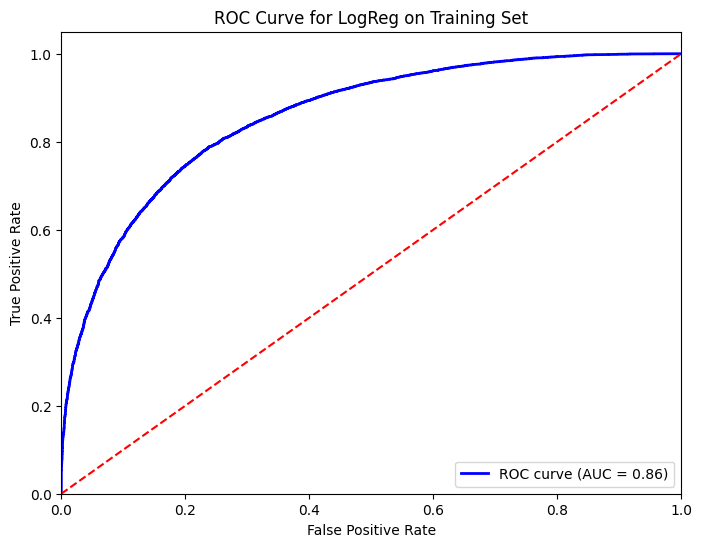

In [36]:
y_pred_prob = logistic_reg.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogReg on Testing Set')
plt.legend(loc="lower right")
plt.show()

y_pred_prob_train = logistic_reg.predict_proba(X_train_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_train)

auc = roc_auc_score(y_train, y_pred_prob_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogReg on Training Set')
plt.legend(loc="lower right")
plt.show()

## Modeling: KNN Classifier

In [37]:
knn_classifier = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [2]
}

grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

best_knn_model = KNeighborsClassifier(**grid_search.best_params_)
best_knn_model.fit(X_train_scaled, y_train)
y_pred = best_knn_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

Best parameters: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Best mean cross-validation score: 0.754473273800955


In [38]:
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.745991168951894
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75      2196
         1.0       0.74      0.75      0.74      2107

    accuracy                           0.75      4303
   macro avg       0.75      0.75      0.75      4303
weighted avg       0.75      0.75      0.75      4303

Confusion Matrix:
[[1632  564]
 [ 529 1578]]


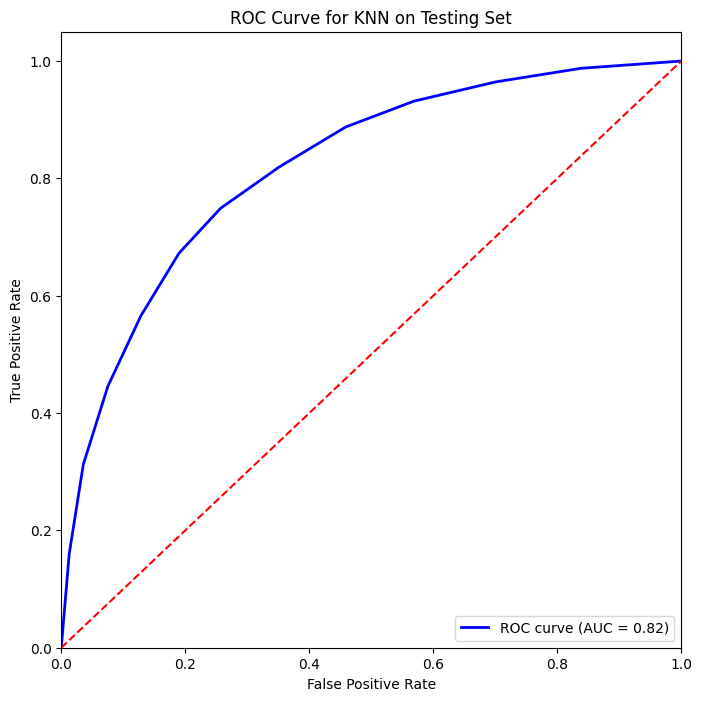

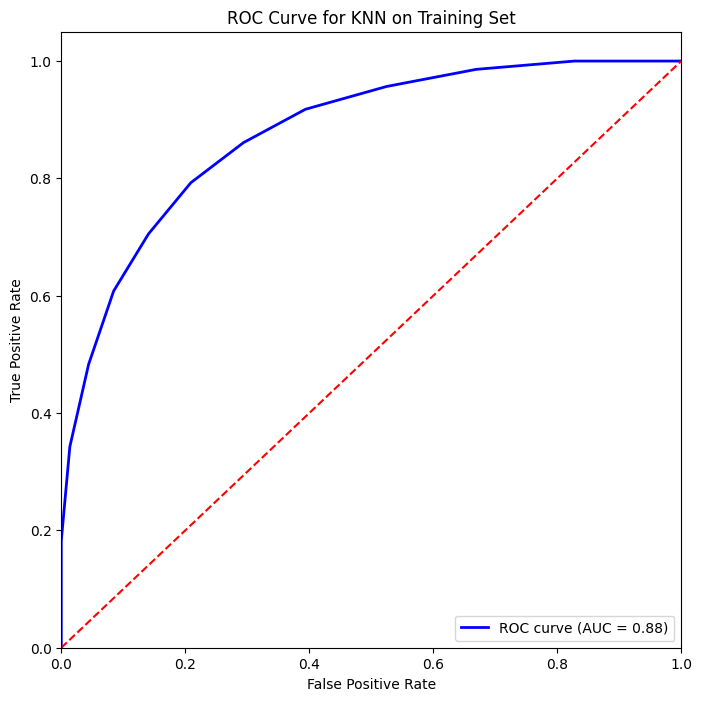

In [39]:
y_pred_prob = best_knn_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN on Testing Set')
plt.legend(loc="lower right")
plt.show()

y_pred_prob_train = best_knn_model.predict_proba(X_train_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_train)

auc = roc_auc_score(y_train, y_pred_prob_train)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN on Training Set')
plt.legend(loc="lower right")
plt.show()

## Modeling: SVM Classifier (SVC)

In [40]:
svm_classifier = SVC(probability = True)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

best_svc_model = SVC(**grid_search.best_params_, probability=True)
best_svc_model.fit(X_train_scaled, y_train)

y_pred = best_svc_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

Best parameters: {'C': 1, 'kernel': 'linear'}
Best mean cross-validation score: 0.7738202448002272


In [41]:
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7536602370439228
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76      2196
         1.0       0.74      0.76      0.75      2107

    accuracy                           0.75      4303
   macro avg       0.75      0.75      0.75      4303
weighted avg       0.75      0.75      0.75      4303

Confusion Matrix:
[[1636  560]
 [ 500 1607]]


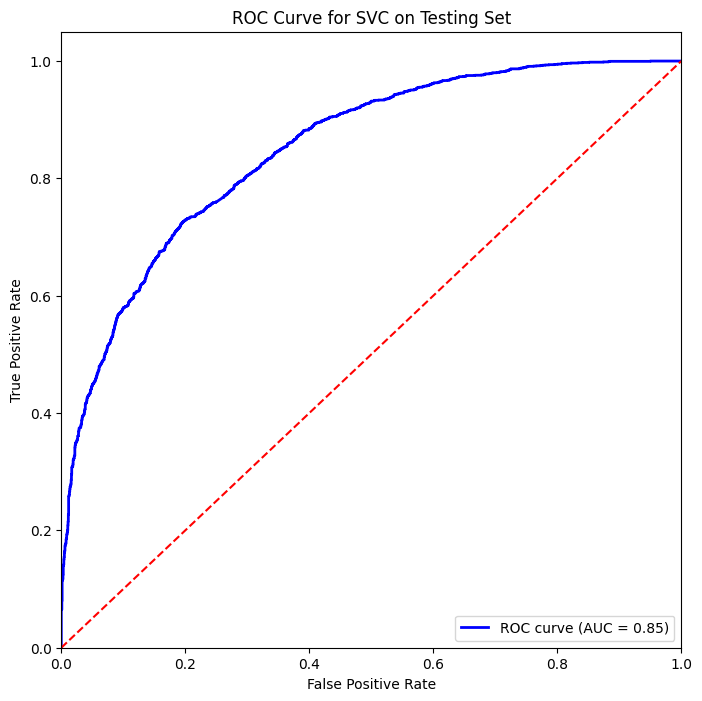

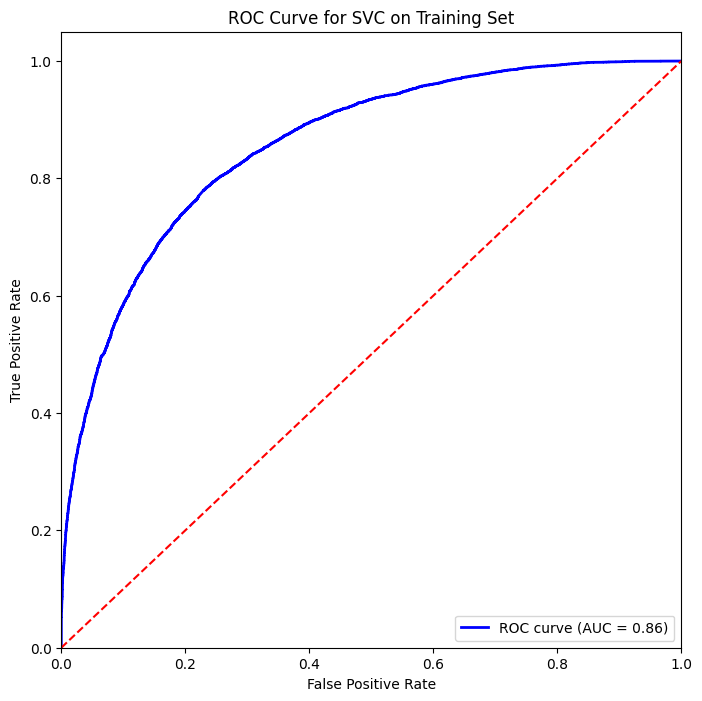

In [42]:
y_pred_prob = best_svc_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVC on Testing Set')
plt.legend(loc="lower right")
plt.show()

y_pred_prob_train = best_svc_model.predict_proba(X_train_scaled)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_prob_train)
auc_train = roc_auc_score(y_train, y_pred_prob_train)

plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVC on Training Set')
plt.legend(loc="lower right")
plt.show()

## Modeling: RandomForestClassifier

In [43]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

best_rfc_model = RandomForestClassifier(**grid_search.best_params_)
best_rfc_model.fit(X_train, y_train)

y_pred = best_rfc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Best parameters: {'max_depth': 10, 'n_estimators': 100}
Best mean cross-validation score: 0.7700436915430056


In [44]:
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7573785730885428
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76      2196
         1.0       0.75      0.77      0.76      2107

    accuracy                           0.76      4303
   macro avg       0.76      0.76      0.76      4303
weighted avg       0.76      0.76      0.76      4303

Confusion Matrix:
[[1646  550]
 [ 494 1613]]


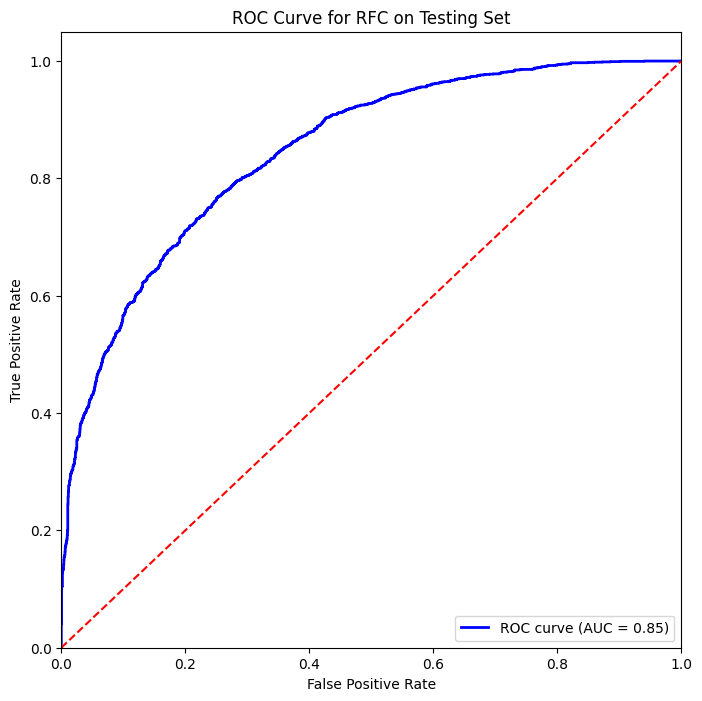

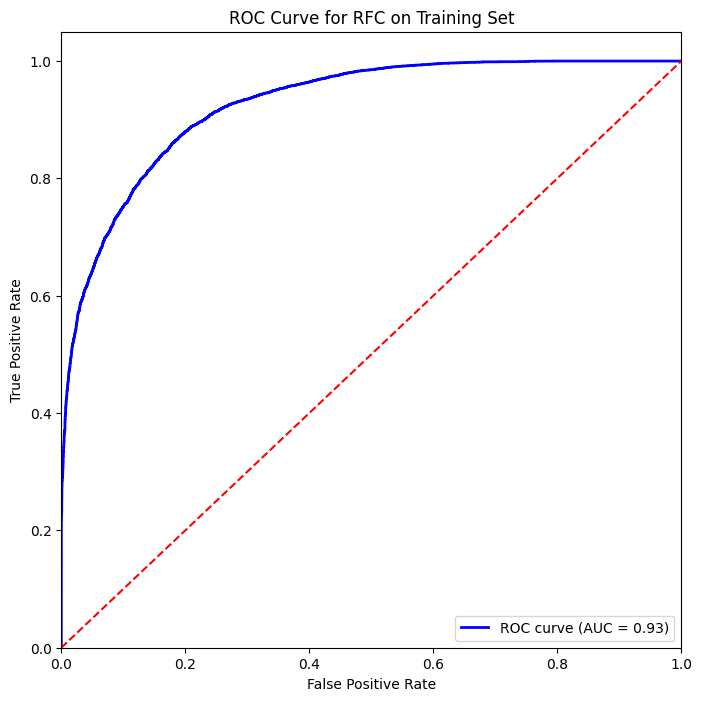

In [45]:
y_pred_prob = best_rfc_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RFC on Testing Set')
plt.legend(loc="lower right")
plt.show()

y_pred_prob_train = best_rfc_model.predict_proba(X_train)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_prob_train)
auc_train = roc_auc_score(y_train, y_pred_prob_train)

plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RFC on Training Set')
plt.legend(loc="lower right")
plt.show()

## Modeling: LightGBM Classifier

In [46]:
lgb_classifier = lgb.LGBMClassifier(verbosity=-1)

param_grid = {
    'num_leaves': [10, 20, 30],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150]
}

grid_search = GridSearchCV(lgb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best mean cross-validation score:", grid_search.best_score_)

best_lgb_model = lgb_classifier.set_params(**grid_search.best_params_)
best_lgb_model.fit(X_train_scaled, y_train)

y_pred = best_lgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 10}
Best mean cross-validation score: 0.7700435902840701


In [47]:
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7543574250522891
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76      2196
         1.0       0.74      0.76      0.75      2107

    accuracy                           0.75      4303
   macro avg       0.75      0.75      0.75      4303
weighted avg       0.75      0.75      0.75      4303

Confusion Matrix:
[[1638  558]
 [ 499 1608]]


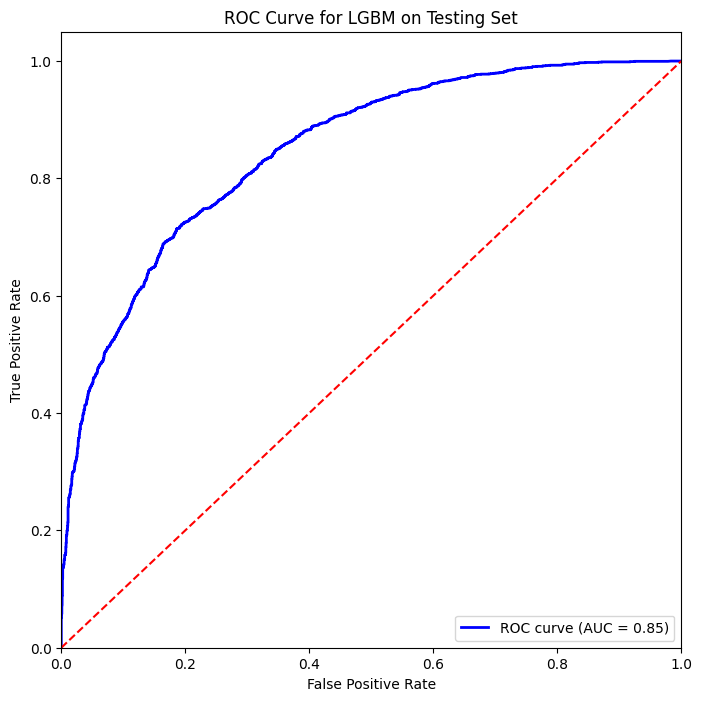

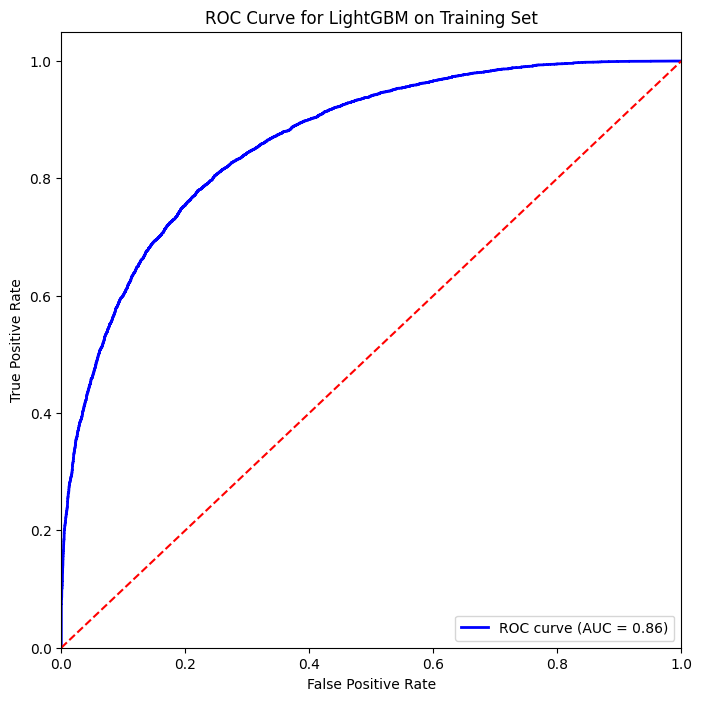

In [48]:
y_pred_prob = best_lgb_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LGBM on Testing Set')
plt.legend(loc="lower right")
plt.show()

y_pred_prob_train = best_lgb_model.predict_proba(X_train_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_train)

auc = roc_auc_score(y_train, y_pred_prob_train)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM on Training Set')
plt.legend(loc="lower right")
plt.show()

## Modeling: Neural Network

In [49]:
X_scaled = scaler.fit_transform(X)

nn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = nn_model.fit(X_train_scaled, y_train, epochs=5, batch_size=128, validation_split=0.2)

test_loss, test_accuracy = nn_model.evaluate(X_train_scaled, y_train)
print('Test accuracy:', test_accuracy)

y_pred = (nn_model.predict(X_test_scaled) > 0.5).astype("int32")
print("Accuracy score:", accuracy_score(y_test, y_pred))

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7053 - loss: 0.5622 - val_accuracy: 0.7688 - val_loss: 0.4869
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7654 - loss: 0.4908 - val_accuracy: 0.7714 - val_loss: 0.4851
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7733 - loss: 0.4793 - val_accuracy: 0.7679 - val_loss: 0.4890
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7713 - loss: 0.4795 - val_accuracy: 0.7685 - val_loss: 0.4862
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7787 - loss: 0.4737 - val_accuracy: 0.7688 - val_loss: 0.4869
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.7772 - loss: 0.4627
Test accuracy: 0.7745177745819092
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
Accuracy score: 0.7559841970718104


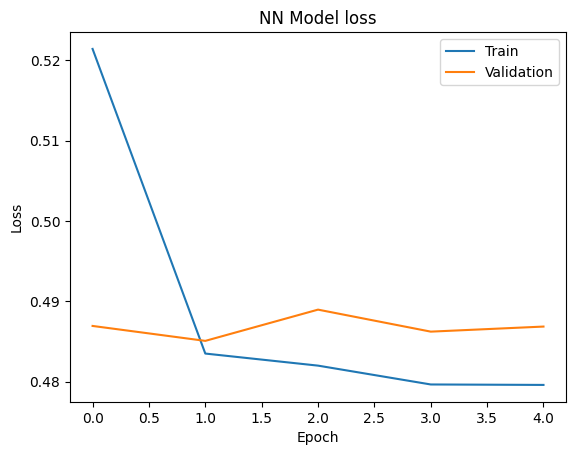

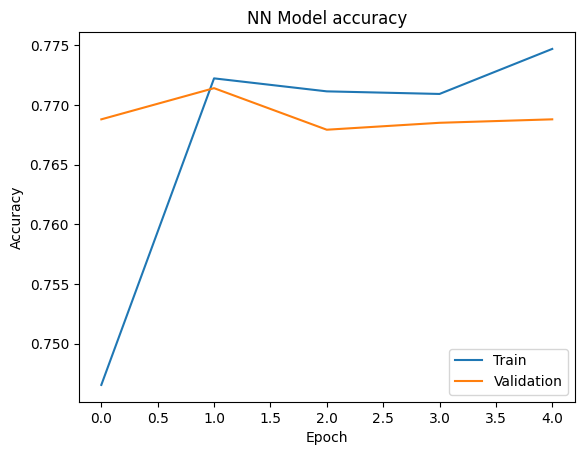

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('NN Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('NN Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


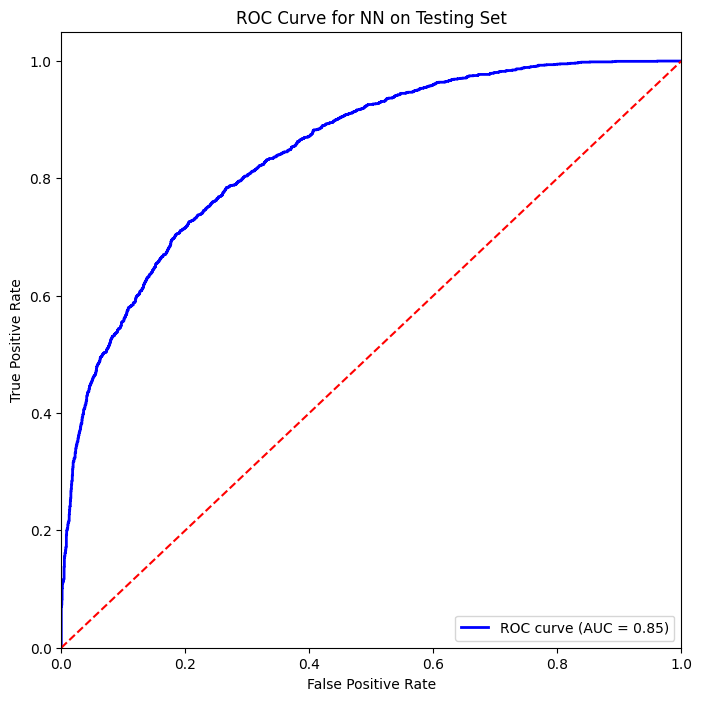

538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


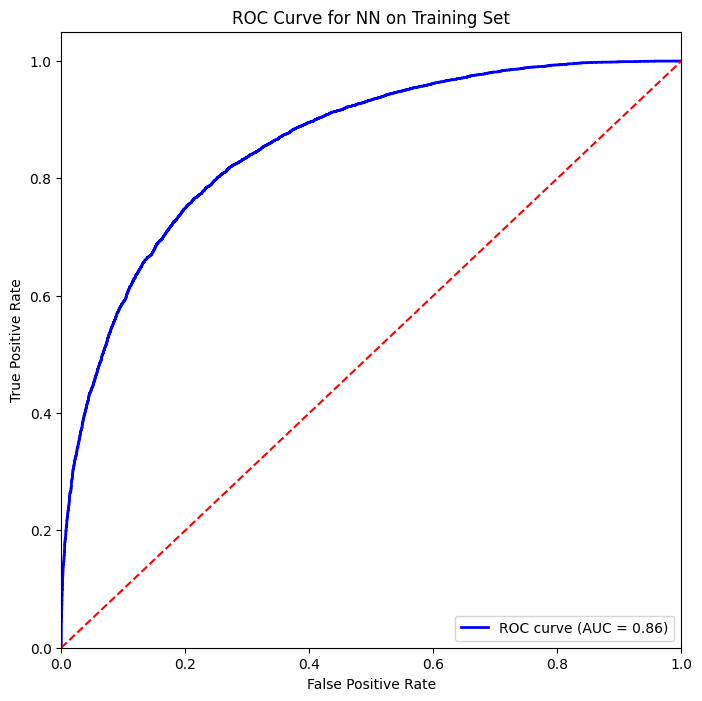

In [51]:
y_pred_prob = nn_model.predict(X_test_scaled).reshape(-1).tolist()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NN on Testing Set')
plt.legend(loc="lower right")
plt.show()

y_pred_prob_train = nn_model.predict(X_train_scaled).reshape(-1).tolist()

fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_train)

auc = roc_auc_score(y_train, y_pred_prob_train)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NN on Training Set')
plt.legend(loc="lower right")
plt.show()